# Demo Notebook

In [1]:
import torch
import urllib
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2

In [ ]:
# Example model taken from "https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/"
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in C:\Users\tejas/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [3]:
# Download an example image
url, filename = ("https://github.com/mateuszbuda/brain-segmentation-pytorch/raw/master/assets/TCGA_CS_4944.png", "sample_mri.png")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

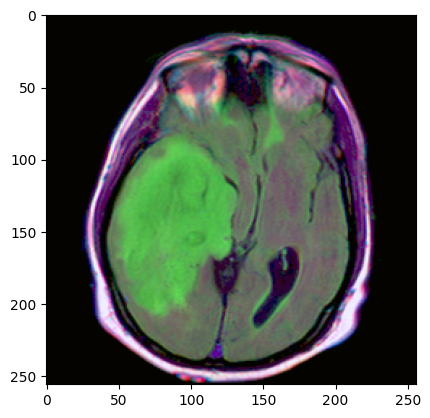

In [4]:
input_image = Image.open(filename)
plt.imshow(input_image)

In [5]:
m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=m, std=s),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model = model.to('cuda')

with torch.no_grad():
    output = model(input_batch)

print(torch.round(output[0]))

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')


In [6]:
print(f"output.shape: {output.shape}")

output.shape: torch.Size([1, 1, 256, 256])


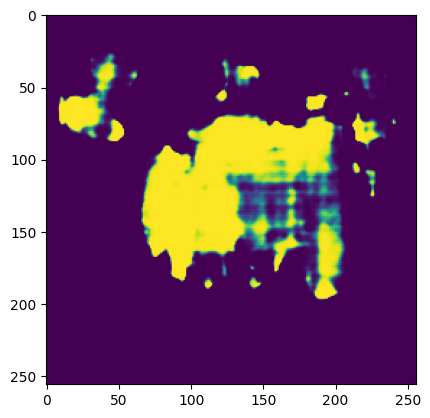

In [7]:
plt.imshow(output[0].permute(1, 2, 0).cpu().numpy())
plt.show()

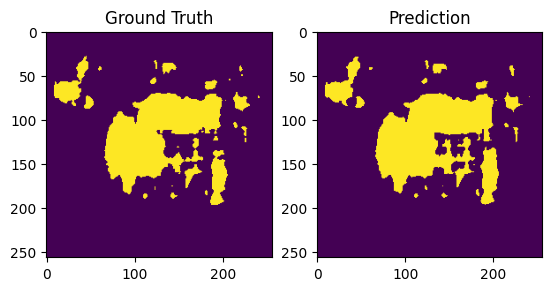

In [8]:
# Using Unet model output to visualize the results
dummy = output.cpu().numpy()
y_true = dummy>0.5 # dummy y_true created by thresholding at 0.5
y_pred = dummy>0.2 # dummy y_pred created by thresholding at 0.2

# morphing y_pred for creating variations between y_true abd y_pred for visulization puposes
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
y_pred = cv2.erode(y_pred[0].astype('uint8'), kernel=kernel).astype('float')
y_pred = np.expand_dims(y_pred, axis=0)

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('Ground Truth')
ax2.title.set_text('Prediction')
ax1.imshow(y_true[0,0])
ax2.imshow(y_pred[0,0])
plt.show()

In [9]:
from monai_wg.metrics import MonaiMetricWrapper

# Initialize
wrapper = MonaiMetricWrapper(num_classes=1, include_background=False)

# Update with prediction and ground truth (B, C, H, W)
wrapper.update(y_pred, y_true)

# Compute Results
results = wrapper.compute()
print(f"Dice: {results['Dice']:.4f}")

Dice: 0.9478


f:\Miniconda\envs\monai\Lib\site-packages\monai\utils\deprecate_utils.py:221: FutureWarning: monai.metrics.utils get_mask_edges:always_return_as_numpy: Argument `always_return_as_numpy` has been deprecated since version 1.5.0. It will be removed in version 1.7.0. The option is removed and the return type will always be equal to the input type.
  warn_deprecated(argname, msg, warning_category)


In [10]:
from monai_wg.metrics import MonaiMetricWrapper

# Initialize
wrapper = MonaiMetricWrapper(num_classes=2, include_background=True)

# Update with prediction and ground truth (B, C, H, W)
wrapper.update(y_pred, y_true)

# Compute Results
results = wrapper.compute()
print(f"Dice: {results['Dice']:.4f}")

Dice: 0.9684


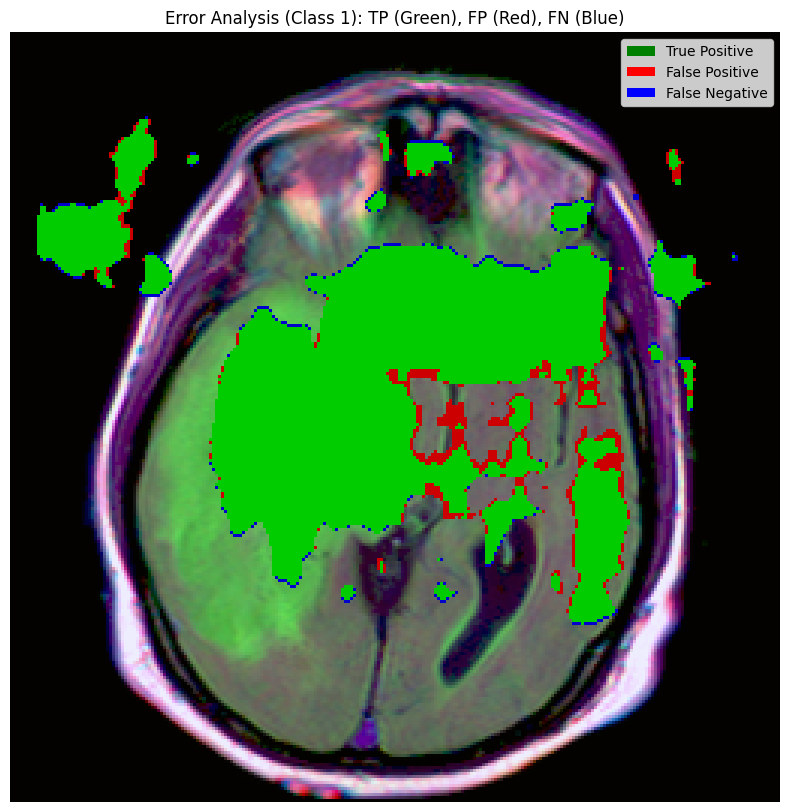

In [11]:
from monai_wg.plotting import plot_segmentation_error_heatmap

plot_segmentation_error_heatmap(image=np.array(input_image), label=y_true[0], pred=y_pred[0])